# Import data

In [1]:
%matplotlib inline

import glob
import os
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import optimizers
from keras.models import Model
from keras import applications
from keras.utils.np_utils import to_categorical 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Using TensorFlow backend.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Dimensions of our images.
img_width, img_height = 240, 240

# n_classes = 6451
# train_data_dir = 'data/train'
# valid_data_dir = 'data/valid'
n_classes = 46
train_data_dir = 'data/train_sample'
valid_data_dir = 'data/valid_sample'

In [4]:
epochs = 100
batch_size = 32

# train_samples = 859486
# valid_samples = 294058
train_samples = 4911
valid_samples = 1690

In [5]:
# train_datagen = ImageDataGenerator(
#         rescale=1. / 255,      # Normalize pixel values to [0,1]
#         shear_range=0.2,       # Randomly applies shearing transformation
#         zoom_range=0.2,        # Randomly applies shearing transformation
#         horizontal_flip=True)  # Randomly flip the images

train_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

# train_generator_bottleneck = train_datagen.flow_from_directory(
#         train_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         class_mode=None,
#         shuffle=False)

Found 4911 images belonging to 46 classes.


In [7]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [8]:
valid_generator = datagen.flow_from_directory(
        valid_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

# valid_generator_bottleneck = datagen.flow_from_directory(
#         valid_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         class_mode=None,
#         shuffle=False)

Found 1690 images belonging to 46 classes.


# Loading VGG 16 models

In [11]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

In [62]:
bottleneck_features_train = model_vgg.predict_generator(train_generator_bottleneck)
np.save(open('models/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [63]:
bottleneck_features_validation = model_vgg.predict_generator(valid_generator_bottleneck)
np.save(open('models/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [64]:
num_classes = len(train_generator_bottleneck.class_indices)

train_data = np.load(open('models/bottleneck_features_train.npy', 'rb'))
train_labels = to_categorical(train_generator_bottleneck.classes[:train_samples], num_classes=num_classes)

validation_data = np.load(open('models/bottleneck_features_validation.npy', 'rb'))
validation_labels = to_categorical(valid_generator_bottleneck.classes[:valid_samples], num_classes=num_classes)

In [13]:
model_top = Sequential()
model_top.add(Flatten(input_shape=model_vgg.output_shape[1:]))
model_top.add(Dense(512, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(n_classes, activation='softmax'))

model_top.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
model_top.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 46)                23598     
Total params: 12,869,166
Trainable params: 12,869,166
Non-trainable params: 0
_________________________________________________________________


# Fine Tuning

In [12]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(n_classes, activation='softmax'))

top_model.load_weights('models/bottleneck_features.h5')

model = Model(inputs=model_vgg.input, outputs=top_model(model_vgg.output))

In [13]:
for layer in model.layers[:15]:
    layer.trainable = False

In [14]:
# Compile the model with a SGD/momentum optimizer and a slow learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 240, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0         
__________

# Build Model

In [29]:
# model = Sequential()
# model.add(Convolution2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Convolution2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Convolution2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(n_classes))
# model.add(Activation('softmax'))

In [30]:
# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

# Training

In [23]:
# Model saving callback
# checkpointer = ModelCheckpoint(filepath='models/data_augmentation.h5', monitor='val_acc', verbose=1, save_best_only=True)
# checkpointer = ModelCheckpoint(filepath='models/bottleneck_features.h5', monitor='val_acc', verbose=1, save_best_only=True)
checkpointer = ModelCheckpoint(filepath='models/finetuning_full.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=2,
        validation_data=valid_generator,
        validation_steps=valid_samples // batch_size,)

# history = model_top.fit(
#         train_data,
#         train_labels,
#         verbose=2,
#         epochs=epochs, 
#         batch_size=batch_size,
#         callbacks=[checkpointer, early_stopping],
#         validation_data=(validation_data, validation_labels))

Epoch 1/100
 - 151s - loss: 0.1069 - acc: 0.9730 - val_loss: 0.5718 - val_acc: 0.9093

Epoch 00001: val_acc improved from -inf to 0.90925, saving model to models/finetuning_full.h5
Epoch 2/100
 - 149s - loss: 0.0499 - acc: 0.9812 - val_loss: 0.5888 - val_acc: 0.9138

Epoch 00002: val_acc improved from 0.90925 to 0.91375, saving model to models/finetuning_full.h5
Epoch 3/100
 - 145s - loss: 0.0611 - acc: 0.9812 - val_loss: 0.4632 - val_acc: 0.9234

Epoch 00003: val_acc improved from 0.91375 to 0.92340, saving model to models/finetuning_full.h5
Epoch 4/100
 - 145s - loss: 0.0408 - acc: 0.9867 - val_loss: 0.5202 - val_acc: 0.9162

Epoch 00004: val_acc did not improve from 0.92340
Epoch 5/100
 - 144s - loss: 0.0389 - acc: 0.9896 - val_loss: 0.6616 - val_acc: 0.9186

Epoch 00005: val_acc did not improve from 0.92340
Epoch 6/100
 - 145s - loss: 0.0435 - acc: 0.9900 - val_loss: 0.5257 - val_acc: 0.9174

Epoch 00006: val_acc did not improve from 0.92340
Epoch 7/100
 - 144s - loss: 0.0334 - acc

# Evaluation

In [ ]:
model.evaluate_generator(valid_generator, valid_samples)
# model_top.evaluate(validation_data, validation_labels)

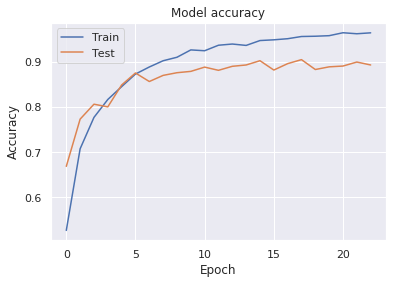

In [73]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#fig.savefig('../images/data_augmentation.svg', format='svg', dpi=1200)